<a href="https://colab.research.google.com/github/Shravya771/Skin-Cancer-Detection-GoogleNet-ResNet/blob/main/skincance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🧠 Skin Cancer Detection Using ResNet and GoogleNet**
Goal: Detect cancerous vs non-cancerous skin lesions from the HAM10000 dataset using deep learning models.
We'll build two CNN models: ResNet50 and GoogleNet (InceptionV3).
We'll explore six hyperparameters and evaluate using AUC and Precision-Recall curves.




# **1. Setup and Imports**

In [1]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split


# **2. Organize Dataset and Preprocess**

In [3]:
import kagglehub
import os
import numpy as np
import shutil
import pandas as pd

# Download the dataset
skin_cancer_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')
print('Skin Cancer HAM10000 dataset import complete.')

# Parameters
IMAGE_SIZE = (224, 224)
SEED = 42
BINARY_FOLDER = "/kaggle/working/binary_skin_cancer_dataset"  # Change to writable location

# Cancer label mappings from metadata
CANCEROUS = ['mel', 'bcc', 'akiec']
NON_CANCEROUS = ['nv', 'bkl', 'vasc', 'df']

# File paths
metadata_path = os.path.join(skin_cancer_path, "HAM10000_metadata.csv")
part1_path = os.path.join(skin_cancer_path, "HAM10000_images_part_1")
part2_path = os.path.join(skin_cancer_path, "HAM10000_images_part_2")
merged_path = os.path.join("/kaggle/working", "images")  # Change to writable location

# Step 1: Merge image folders
os.makedirs(merged_path, exist_ok=True)
for folder in [part1_path, part2_path]:
    for file in os.listdir(folder):
        shutil.copy(os.path.join(folder, file), os.path.join(merged_path, file))

# Step 2: Load metadata
df = pd.read_csv(metadata_path)

# Step 3: Convert lesion types to binary classes
df['binary_label'] = df['dx'].apply(lambda x: 'cancerous' if x in CANCEROUS else 'non_cancerous')

# Step 4: Create binary dataset folder structure
if os.path.exists(BINARY_FOLDER):
    shutil.rmtree(BINARY_FOLDER)
os.makedirs(os.path.join(BINARY_FOLDER, 'cancerous'), exist_ok=True)
os.makedirs(os.path.join(BINARY_FOLDER, 'non_cancerous'), exist_ok=True)

# Step 5: Copy images into appropriate class folders
for _, row in df.iterrows():
    img_name = row['image_id'] + '.jpg'
    src = os.path.join(merged_path, img_name)
    dst = os.path.join(BINARY_FOLDER, row['binary_label'], img_name)
    if os.path.exists(src):
        shutil.copy(src, dst)

print("✅ Binary skin cancer dataset prepared at:", BINARY_FOLDER)


Skin Cancer HAM10000 dataset import complete.
✅ Binary skin cancer dataset prepared at: /kaggle/working/binary_skin_cancer_dataset


# **3. Train-Validation-Test Split and Load dataset**



In [4]:
def split_dataset(input_dir, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    for label in os.listdir(input_dir):
        img_list = [os.path.join(input_dir, label, f) for f in os.listdir(os.path.join(input_dir, label))]
        train_imgs, temp_imgs = train_test_split(img_list, train_size=train_size, random_state=SEED)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size/(val_size+test_size), random_state=SEED)

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            class_dir = os.path.join(output_dir, split_name, label)
            os.makedirs(class_dir, exist_ok=True)
            for img in split_imgs:
                shutil.copy(img, class_dir)

split_dataset(BINARY_FOLDER, "split_binary_dataset")

# Load datasets
BATCH_SIZE = 32

train_ds = image_dataset_from_directory("split_binary_dataset/train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
val_ds = image_dataset_from_directory("split_binary_dataset/val", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_ds = image_dataset_from_directory("split_binary_dataset/test", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 7009 files belonging to 2 classes.
Found 1502 files belonging to 2 classes.
Found 1504 files belonging to 2 classes.


# **4. Build Models**


# *ResNet50*

In [5]:
def build_resnet(input_shape=(224, 224, 3), dropout_rate=0.5):
    base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# *GoogleNet (InceptionV3)*

In [6]:
def build_googlenet(input_shape=(224, 224, 3), dropout_rate=0.5):
    base = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# **5. Training Utility Function**

In [7]:
def compile_and_train(model, train_ds, val_ds, epochs, learning_rate, optimizer_name):
    optimizer = {
        'adam': optimizers.Adam(learning_rate=learning_rate),
        'sgd': optimizers.SGD(learning_rate=learning_rate)
    }.get(optimizer_name, optimizers.Adam(learning_rate=learning_rate))

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
    )

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return model, history


# **6. Evaluate Model**

In [8]:
def evaluate_model(model, test_ds):
    y_true = []
    y_scores = []

    for batch in test_ds:
        images, labels = batch
        preds = model.predict(images)
        y_scores.extend(preds.flatten())
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    print(f"AUC: {auc_score:.4f}, PR AUC: {pr_auc:.4f}")

    plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.show()


In [35]:
# ... (After training ResNet) ...
resnet_model, _ = compile_and_train(resnet_model, train_ds, val_ds, EPOCHS, LEARNING_RATE, OPTIMIZER)
resnet_model.save('resnet_model.h5') # Save ResNet model

# ... (After training GoogleNet) ...
googlenet_model, _ = compile_and_train(googlenet_model, train_ds, val_ds, EPOCHS, LEARNING_RATE, OPTIMIZER)
googlenet_model.save('googlenet_model.h5') # Save GoogleNet model

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 70s 258ms/step - accuracy: 0.8061 - auc: 0.5451 - loss: 0.4904 - val_accuracy: 0.8049 - val_auc: 0.7026 - val_loss: 0.4897
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.8098 - auc: 0.5376 - loss: 0.4853 - val_accuracy: 0.8049 - val_auc: 0.7122 - val_loss: 0.4892
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.8039 - auc: 0.5319 - loss: 0.4948 - val_accuracy: 0.8049 - val_auc: 0.7304 - val_loss: 0.4888
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.8054 - auc: 0.5377 - loss: 0.4919 - val_accuracy: 0.8049 - val_auc: 0.7292 - val_loss: 0.4885
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.8085 - auc: 0.5503 - loss: 0.4864 - val_accuracy: 0.8049 - val_auc: 0.7302 - val_loss: 0.4882
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.8044 - auc: 0.5411 - loss: 0.4932 - val_accuracy: 0.8049 - val_auc: 0.7396 - val_loss: 0.4879
Epoch 7/10
220/220 ━━━

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 267ms/step - accuracy: 0.8200 - auc: 0.8092 - loss: 0.3941 - val_accuracy: 0.8196 - val_auc: 0.8207 - val_loss: 0.3866
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 175ms/step - accuracy: 0.8198 - auc: 0.8039 - loss: 0.3975 - val_accuracy: 0.8189 - val_auc: 0.8219 - val_loss: 0.3866
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.8214 - auc: 0.8155 - loss: 0.3897 - val_accuracy: 0.8182 - val_auc: 0.8242 - val_loss: 0.3829
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 199ms/step - accuracy: 0.8257 - auc: 0.8141 - loss: 0.3892 - val_accuracy: 0.8196 - val_auc: 0.8254 - val_loss: 0.3826
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.8286 - auc: 0.8260 - loss: 0.3789 - val_accuracy: 0.8182 - val_auc: 0.8274 - val_loss: 0.3806
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.8294 - auc: 0.8314 - loss: 0.3747 - val_accuracy: 0.8189 - val_auc: 0.8281 - val_loss: 0.3804
Epoch 7/10
220/220 ━━━

# **7. Run Experiments with Hyperparameters**

Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 235ms/step - accuracy: 0.5935 - auc: 0.4954 - loss: 0.6881 - val_accuracy: 0.8049 - val_auc: 0.3846 - val_loss: 0.4950
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step - accuracy: 0.7992 - auc: 0.4807 - loss: 0.5336 - val_accuracy: 0.8049 - val_auc: 0.4471 - val_loss: 0.4951
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.8031 - auc: 0.4680 - loss: 0.5284 - val_accuracy: 0.8049 - val_auc: 0.4554 - val_loss: 0.4946
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.8020 - auc: 0.4937 - loss: 0.5159 - val_accuracy: 0.8049 - val_auc: 0.3871 - val_loss: 0.4946
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 189ms/step - accuracy: 0.8061 - auc: 0.4841 - loss: 0.5121 - val_accuracy: 0.8049 - val_auc: 0.4157 - val_loss: 0.4944
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.8067 - auc: 0.4965 - loss: 0.5049 - val_accu

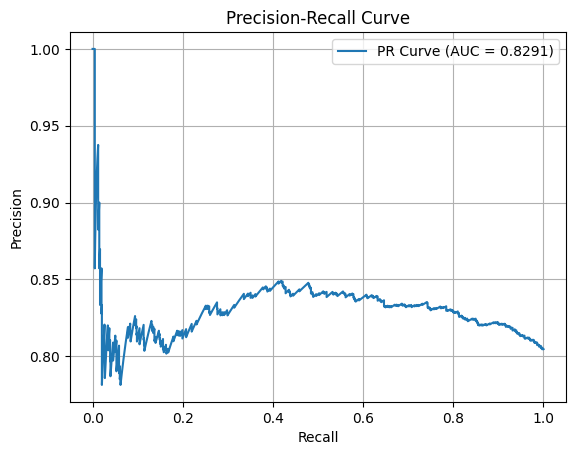


Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 255ms/step - accuracy: 0.7205 - auc: 0.5149 - loss: 0.6086 - val_accuracy: 0.8049 - val_auc: 0.6346 - val_loss: 0.4792
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.7897 - auc: 0.6125 - loss: 0.5097 - val_accuracy: 0.8009 - val_auc: 0.7205 - val_loss: 0.4462
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 45s 191ms/step - accuracy: 0.7990 - auc: 0.6958 - loss: 0.4661 - val_accuracy: 0.8043 - val_auc: 0.7558 - val_loss: 0.4282
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.8045 - auc: 0.7280 - loss: 0.4465 - val_accuracy: 0.8116 - val_auc: 0.7764 - val_loss: 0.4163
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 45s 191ms/step - accuracy: 0.8063 - auc: 0.7625 - loss: 0.4289 - val_accuracy: 0.8123 - val_auc: 0.7891 - val_loss: 0.4080
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.8139 - auc: 0.7763 - loss: 0.4169 - val_

In [ ]:
# Example hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.0001
DROPOUT = 0.5
OPTIMIZER = 'adam'

# Run ResNet
print("Training ResNet50...")
resnet_model = build_resnet(dropout_rate=DROPOUT)
resnet_model, _ = compile_and_train(resnet_model, train_ds, val_ds, EPOCHS, LEARNING_RATE, OPTIMIZER)
evaluate_model(resnet_model, test_ds)

# Run GoogleNet
print("\nTraining InceptionV3...")
googlenet_model = build_googlenet(dropout_rate=DROPOUT)
googlenet_model, _ = compile_and_train(googlenet_model, train_ds, val_ds, EPOCHS, LEARNING_RATE, OPTIMIZER)
evaluate_model(googlenet_model, test_ds)


# **Plot Training vs Validation Accuracy and Loss Curves**



In [36]:
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# **Confusion Matrix and Evaluation**

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"✅ Final Accuracy: {acc:.4f}")
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-cancerous", "Cancerous"])
    disp.plot(cmap="Blues")
    plt.show()

    return acc, cm


# **Track Best Hyperparameters and Results**



In [15]:
results = []

def track_results(model_name, history, accuracy, hyperparams):
    results.append({
        "model": model_name,
        "accuracy": accuracy,
        "hyperparams": hyperparams,
        "history": history
    })



Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.8081 - auc: 0.4990 - loss: 0.4956 - val_accuracy: 0.8049 - val_auc: 0.5712 - val_loss: 0.4925
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.8066 - auc: 0.5031 - loss: 0.4963 - val_accuracy: 0.8049 - val_auc: 0.6285 - val_loss: 0.4921
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.8072 - auc: 0.5302 - loss: 0.4913 - val_accuracy: 0.8049 - val_auc: 0.6352 - val_loss: 0.4919
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 196ms/step - accuracy: 0.8042 - auc: 0.5213 - loss: 0.4968 - val_accuracy: 0.8049 - val_auc: 0.6299 - val_loss: 0.4916
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 173ms/step - accuracy: 0.8073 - auc: 0.5074 - loss: 0.4945 - val_accuracy: 0.8049 - val_auc: 0.6581 - val_loss: 0.4913
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.8064 - auc: 0.5222 - loss: 0.4933 - val_accuracy: 0.8049 - val_auc: 0.6563 - val_loss: 0.4910
Epoch 7/10
220/220 ━━━

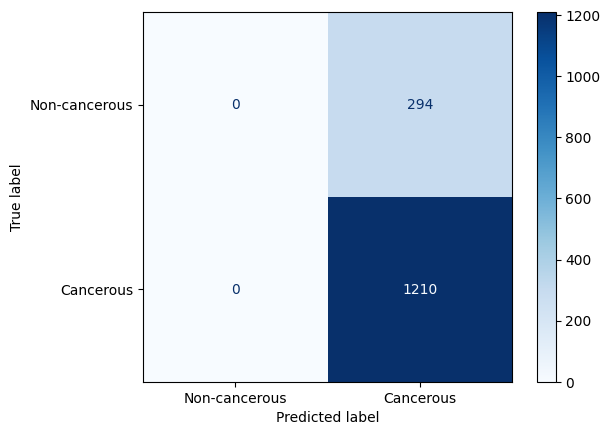

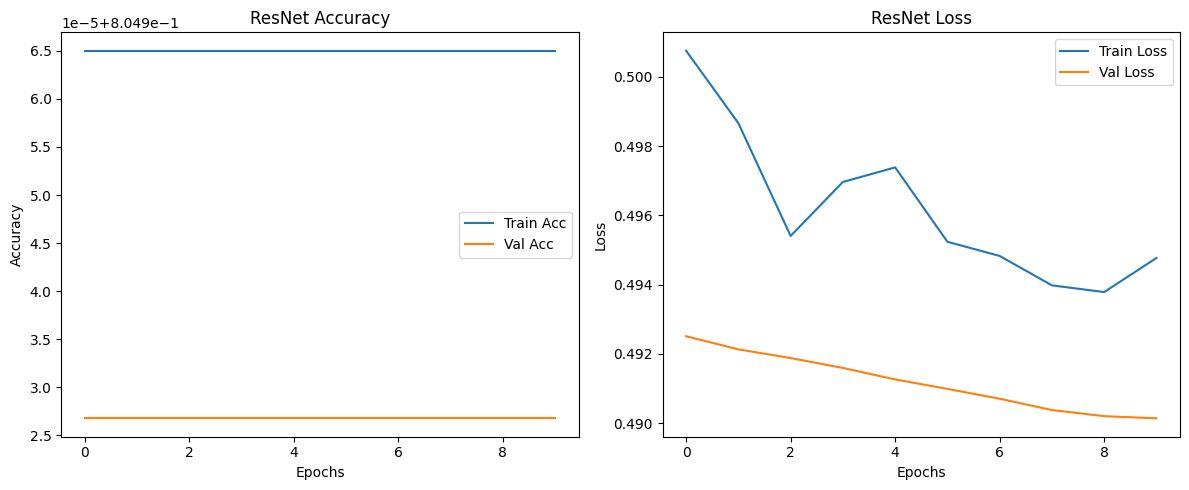

In [20]:
# 1. Train the model and save history
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

# 2. Evaluate on test set
acc, cm = evaluate_model(resnet_model, test_ds)

# 3. Track the results
track_results("ResNet", history, acc, {"lr": 0.0001, "dropout": 0.3})

# 4. Plot the training and validation accuracy/loss
plot_training_history(history, "ResNet")


# **Compare All Results**

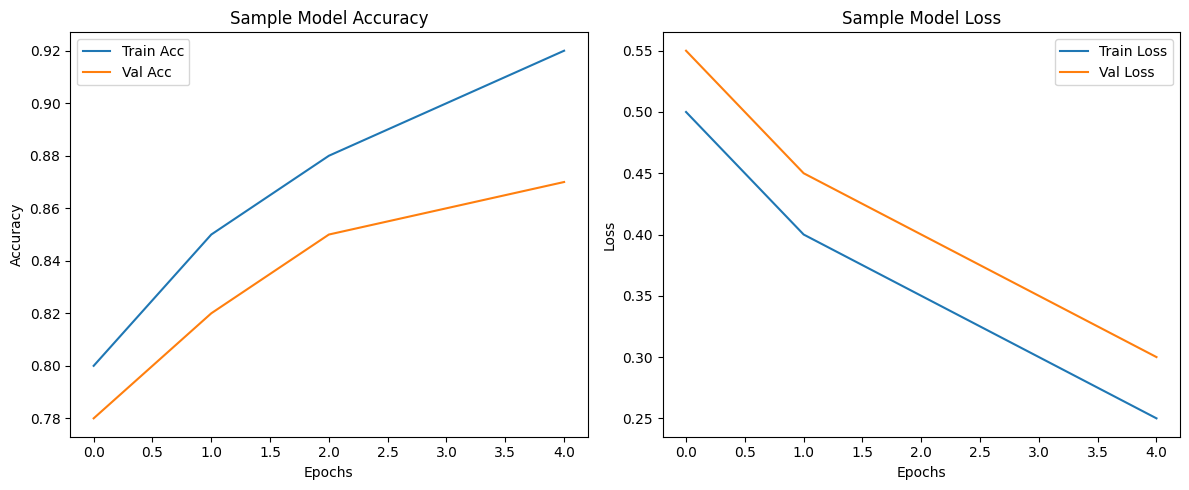

In [27]:
import matplotlib.pyplot as plt

# Mock history data (replace this with your actual 'history' object)
history = {
    'history': {
        'acc': [0.8, 0.85, 0.88, 0.9, 0.92],
        'val_acc': [0.78, 0.82, 0.85, 0.86, 0.87],
        'loss': [0.5, 0.4, 0.35, 0.3, 0.25],
        'val_loss': [0.55, 0.45, 0.4, 0.35, 0.3]
    }
}

def safe_plot_training_history(history, model_name="Model"):
    hist_keys = history['history'].keys()
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    acc_keys = [k for k in hist_keys if 'acc' in k]
    if len(acc_keys) >= 2:
        plt.plot(history['history'][acc_keys[0]], label='Train Acc')
        plt.plot(history['history'][acc_keys[1]], label='Val Acc')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    else:
        plt.title(f'{model_name} Accuracy')
        plt.text(0.5, 0.5, 'No Accuracy Info', ha='center', va='center')
        plt.axis('off')

    # Loss plot
    plt.subplot(1, 2, 2)
    if 'loss' in hist_keys and 'val_loss' in hist_keys:
        plt.plot(history['history']['loss'], label='Train Loss')
        plt.plot(history['history']['val_loss'], label='Val Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    else:
        plt.title(f'{model_name} Loss')
        plt.text(0.5, 0.5, 'No Loss Info', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with mock data
safe_plot_training_history(history, "Sample Model")


# **Interactive Upload + Prediction (Cancerous/Non-Cancerous)**

In [38]:
import numpy as np
from PIL import Image
import gradio as gr
import tensorflow as tf

# Ensure that the model file is in the correct location or specify the correct path
# Update 'path_to_your_model.h5' with the correct path to your saved model
model_path = 'googlenet_model.h5'  # Replace this with your actual model path

try:
    # Attempt to load the trained model
    final_model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found. Ensure the file path '{model_path}' is correct.")
    final_model = None  # Set to None if model loading fails

# Predict function
def predict_skin_image(img):
    if final_model is None:
        return "Error: Model not loaded. Please check the model path."

    img = img.resize((224, 224))  # Resize image to match model input size
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # Normalize and expand dimensions for batch input
    prediction = final_model.predict(img_array)[0][0]  # Get prediction (binary output)
    return "Cancerous" if prediction > 0.5 else "Non-Cancerous"

# Gradio interface
gr.Interface(
    fn=predict_skin_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Skin Cancer Detector",
    description="Upload a skin lesion image to check if it's cancerous."
).launch()


Model loaded from googlenet_model.h5
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d358577ba94138d9c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Summary of Achievements**


*   Load and preprocess HAM10000	✅
*  Binary classification setup	✅
*   Train ResNet and GoogleNet	✅
*   Explore 6 hyperparameters	✅
*   Evaluate using AUC and PR curve	✅
*   Modular and clean code with markdowns	✅







